In [1]:
import pandas 
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from skimage.io import imread_collection
from tqdm import tqdm 
import os
import cv2
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import random_rotation

2024-08-03 17:42:15.775938: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 17:42:17.463747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def read_images_from_directory(image_path ,SIZE ):
    img_array = []
    image_file = os.listdir(image_path)
    for i in tqdm(image_file):
        image = cv2.imread(image_path + '/' + i,1)
        
        # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))
        
        # normalizing image 
        image = image.astype('float32') / 255.0
        
        #appending normal normal image    
        img_array.append(img_to_array(image))
    return img_array

SIZE = 256

train_image = read_images_from_directory('data/Original', SIZE )
train_sketch_image = read_images_from_directory('data/Sketchs', SIZE)


100%|██████████| 405/405 [00:08<00:00, 49.74it/s]


In [3]:

train_image = np.reshape(train_image, (len(train_image), SIZE, SIZE, 3))
train_sketch_image = np.reshape(train_sketch_image, (len(train_sketch_image), SIZE, SIZE, 3))

In [23]:
print('total training images:', len(train_image))
print('total training sketch:', len(train_sketch_image))

total training images: 405
total training sketch: 405


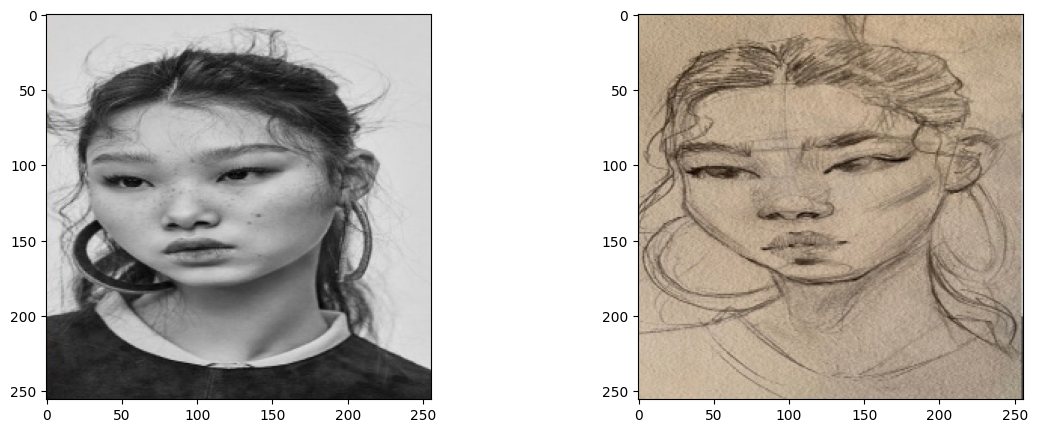

In [4]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(train_image[14])
plt.subplot(122)
plt.imshow(train_sketch_image[14])

In [5]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

In [6]:
def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU()) 
    return upsample

In [7]:
SIZE = 256
def model():
    encoder_input = keras.Input(shape = (SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32,4)(x)
    x = downsample(64,4,False)(x)
    x = downsample(128,4)(x)
    x = downsample(256,4)(x)
   
    encoder_output = downsample(512,4)(x)
    
    decoder_input = upsample(512,4,True)(encoder_output)
    x = upsample(256,4,False)(decoder_input)
    x = upsample(128,4, True)(x)
    x = upsample(64,4)(x)
    x = upsample(32,4)(x)
    x = upsample(16,4)(x)
    x = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (1,1), padding = 'valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3,(2,2),strides = (1,1), padding = 'valid')(x)
    
  
    return tf.keras.Model(encoder_input, decoder_output)

In [8]:
model = model()
model.summary()

2024-08-03 17:42:33.569675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03 17:42:33.717582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03 17:42:33.718089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03 17:42:33.720987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03 17:42:33.721439: I tensorflow/compile

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 127, 127, 16)      768       
                                                                 
 sequential_1 (Sequential)   (None, 62, 62, 32)        8320      
                                                                 
 sequential_2 (Sequential)   (None, 30, 30, 64)        32768     
                                                                 
 sequential_3 (Sequential)   (None, 14, 14, 128)       131584    
                                                                 
 sequential_4 (Sequential)   (None, 6, 6, 256)         525312    
                                                                 
 sequential_5 (Sequential)   (None, 2, 2, 512)         209920

In [9]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error', metrics = ['acc'])

In [10]:
history = model.fit(train_image, train_sketch_image, epochs = 1000, verbose = 1)

Epoch 1/500


2024-08-03 17:42:37.507656: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_6/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-03 17:42:38.065253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-08-03 17:42:38.196322: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-08-03 17:42:38.206716: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-08-03 17:42:38.206783: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-08-03 17:42:38.206895: W tensorflow

 3/13 [=====>........................] - ETA: 0s - loss: 0.6964 - acc: 0.4857 

2024-08-03 17:42:45.859580: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



13/13 [==============================] - 14s 359ms/step - loss: 0.5068 - acc: 0.3809
Epoch 2/500
13/13 [==============================] - 1s 61ms/step - loss: 0.2309 - acc: 0.3638
Epoch 3/500
13/13 [==============================] - 1s 63ms/step - loss: 0.1688 - acc: 0.3757
Epoch 4/500
13/13 [==============================] - 1s 60ms/step - loss: 0.1488 - acc: 0.3812
Epoch 5/500
13/13 [==============================] - 1s 60ms/step - loss: 0.1532 - acc: 0.3821
Epoch 6/500
13/13 [==============================] - 1s 59ms/step - loss: 0.1385 - acc: 0.4091
Epoch 7/500
13/13 [==============================] - 1s 58ms/step - loss: 0.1268 - acc: 0.4115
Epoch 8/500
13/13 [==============================] - 1s 64ms/step - loss: 0.1231 - acc: 0.4139
Epoch 9/500
13/13 [==============================] - 1s 59ms/step - loss: 0.1185 - acc: 0.4309
Epoch 10/500
13/13 [==============================] - 1s 63ms/step - loss: 0.1167 - acc: 0.4278
Epoch 11/500
13/13 [==============================] - 1s 58

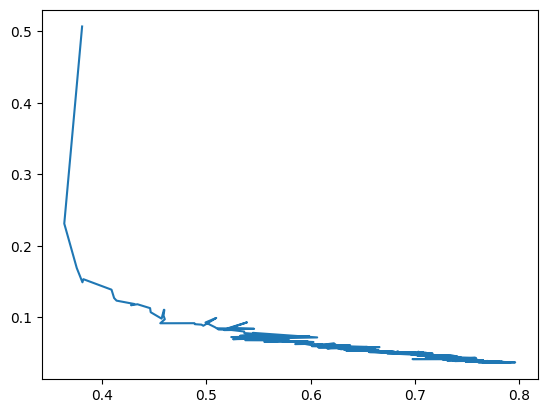

In [11]:
plt.plot(history.history['acc'] , history.history['loss'])

In [12]:
img = cv2.imread("test.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (SIZE, SIZE))
img = img.astype('float32') / 255.0

In [13]:
pred_img = model.predict(img.reshape(1, 256, 256, 3))

1/1 [==============================] - 2s 2s/step


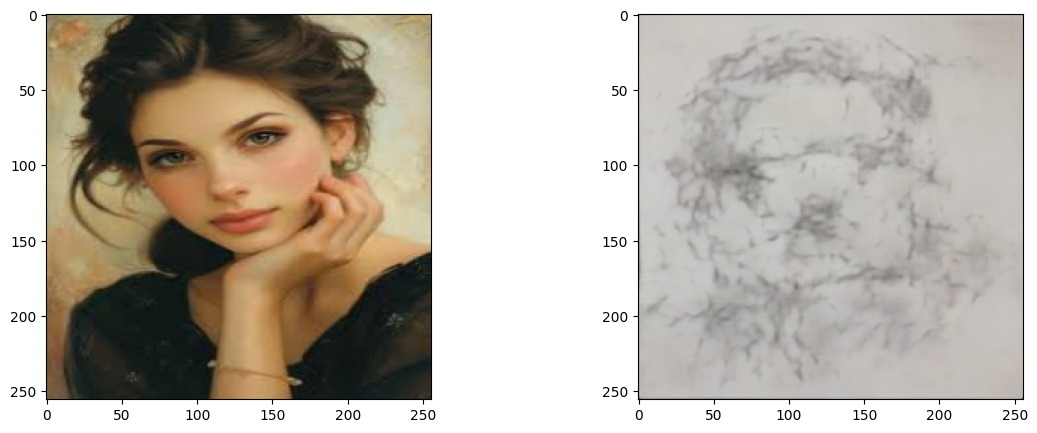

In [14]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(pred_img.reshape(256, 256, 3))

In [22]:
img_sketch = cv2.imread("Sketch_data/Sketchs/4.jpg")
img_sketch = cv2.cvtColor(img_sketch, cv2.COLOR_BGR2RGB)
img_sketch = cv2.resize(img_sketch, (SIZE, SIZE))
img_sketch = img_sketch.astype('float32') / 255.0

pred_img = model.predict(img_sketch.reshape(1, 256, 256, 3))

1/1 [==============================] - 0s 30ms/step


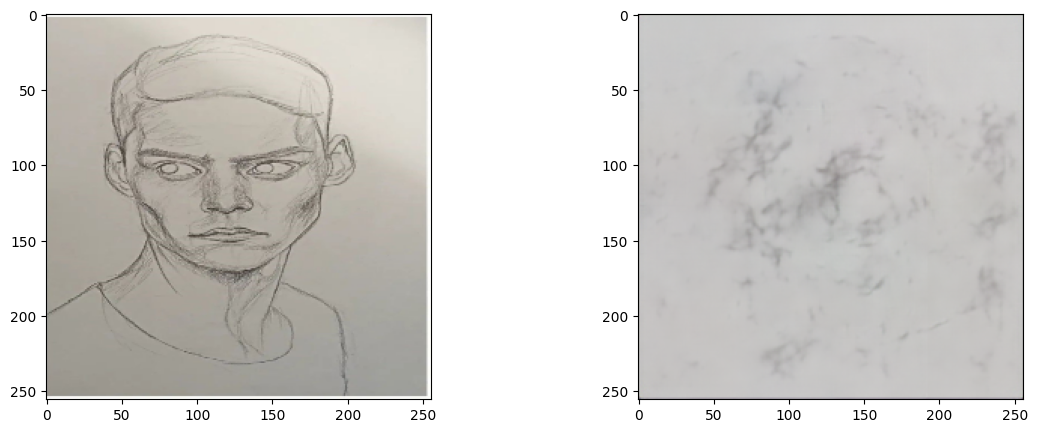

In [23]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(img_sketch)
plt.subplot(122)
plt.imshow(pred_img.reshape(256, 256, 3))

In [1]:
from PIL import Image
import numpy as np
import os
from keras.preprocessing.image import img_to_array

def read_images_from_directory(directory, img_size=(256, 256)):
    image_arrays = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.png')):
            try:
                img = Image.open(os.path.join(directory, filename)).resize(img_size)
                img_array = img_to_array(img)
                image_arrays.append(img_array)
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
    return np.array(image_arrays)

# Test loading images
image_arrays = read_images_from_directory('data/Original')
print(f"Loaded {len(image_arrays)} images.")


2024-08-03 18:51:24.592615: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 18:51:26.085477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loaded 405 images.


In [2]:
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array

def apply_transformations(images):
    transformations = [
        lambda x: cv2.flip(x, 1),
        lambda x: cv2.flip(x, -1),
        lambda x: cv2.flip(cv2.flip(x, -1), 1),
        lambda x: cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE),
        lambda x: cv2.flip(cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE), 1),
        lambda x: cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE),
        lambda x: cv2.flip(cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE), 1),
    ]

    transformed_images = []

    for image in images:
        if not isinstance(image, np.ndarray):
            print("Error: Image is not a numpy array.")
            continue

        for transformation in transformations:
            try:
                transformed_image = transformation(image.copy())
                transformed_images.append(img_to_array(transformed_image))
            except Exception as e:
                print(f"Error applying transformation: {e}")

    return np.array(transformed_images)

# Test transformations on a small batch
if len(image_arrays) > 0:
    small_batch = image_arrays[:5]  # Take only the first 5 images for testing
    transformed_array = apply_transformations(small_batch)
    print(f"Transformed {len(transformed_array)} images.")
else:
    print("No images to transform.")


Transformed 35 images.


In [3]:
SIZE = 256

# Only reshape if there are transformed images
if 'transformed_array' in locals() and transformed_array.size > 0:
    try:
        train_image = np.reshape(transformed_array, (len(transformed_array), SIZE, SIZE, 3))
        print(f"Reshaped images to {train_image.shape}.")
    except Exception as e:
        print(f"Error reshaping images: {e}")
else:
    print("No transformed images available for reshaping.")


Reshaped images to (35, 256, 256, 3).
